### 1. Lets first download the data

In [84]:
import pandas as pd
import numpy as np
import os

In [85]:
cel_data = pd.read_csv("raw_data/cel.csv")

### 2 We are going to start out by trying the SVM on just one species

In [86]:
num_rows = cel_data.shape[0]
print("num caenorhabditis elegans in raw set", num_rows)
cel_data = cel_data.dropna()
print("num caenorhabditis elegans after dropping N/A", cel_data.shape[0])


num caenorhabditis elegans in raw set 1737349
num caenorhabditis elegans after dropping N/A 1737349


In [39]:
cel_data.columns

Index(['sequence_names', 'nt_proportion0', 'nt_proportion1', 'nt_proportion2',
       'nt_proportion3', 'dinucleotide_proportion0',
       'dinucleotide_proportion1', 'dinucleotide_proportion2',
       'dinucleotide_proportion3', 'dinucleotide_proportion4',
       'dinucleotide_proportion5', 'dinucleotide_proportion6',
       'dinucleotide_proportion7', 'dinucleotide_proportion8',
       'dinucleotide_proportion9', 'dinucleotide_proportion10',
       'dinucleotide_proportion11', 'dinucleotide_proportion12',
       'dinucleotide_proportion13', 'dinucleotide_proportion14',
       'dinucleotide_proportion15', 'gc_content', 'gc_ratio',
       'sequence_length', 'stem_number', 'avg_bp_stem', 'longest_stem_length',
       'terminal_loop_length', 'bp_number', 'dP', 'bp_proportion0',
       'bp_proportion1', 'bp_proportion2', 'bp_proportion_stem0',
       'bp_proportion_stem1', 'bp_proportion_stem2', 'triplets0', 'triplets1',
       'triplets2', 'triplets3', 'triplets4', 'triplets5', 'triplets

#### Chosen features are based on the feature imporance RFC ran in miRNA_prediction_model

In [87]:
cel_y = cel_data['CLASS']
cel_x = cel_data[['mfe', 'efe', 'dG', 'triplets0', 'mfei4', 'dP', 'bp_number']]

In [88]:
print("Example testing: ", cel_y[0])
print("Examples features: ", cel_x.iloc[0])
#convert our data to numpy
cel_test_np = cel_y.values
cel_data_np = cel_x.values


Example testing:  1
Examples features:  mfe         -68.200000
efe         -71.830000
dG           -0.483688
triplets0     0.138462
mfei4        -1.196491
dP            0.404255
bp_number    57.000000
Name: 0, dtype: float64


### Split into train, test and validation

In [89]:
from sklearn.model_selection import train_test_split


### This will split code into 60-20-20 split for training, validation, and testing

In [90]:
# Splitting data into 80% train and 20% test
train_x, test_x, train_y, test_y = train_test_split(cel_x, cel_y, test_size=0.2, random_state=15)

# Further splitting the remaining 80% into 75% train and 25% validation
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25, random_state=15)
print(len(val_y))

347470


In [91]:
import torch

train_x = torch.tensor(train_x.values, dtype=torch.float32)
train_y = torch.tensor(train_y.values, dtype=torch.float32)
val_x = torch.tensor(val_x.values, dtype=torch.float32)
val_y = torch.tensor(val_y.values, dtype=torch.float32)
test_x = torch.tensor(test_x.values, dtype=torch.float32)
test_y = torch.tensor(test_y.values, dtype=torch.float32)


## Lets make the SVM non-linear model now!

In [92]:
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score

In [93]:
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
test_dataset = torch.utils.data.TensorDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

### Create the class

In [95]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.utils import resample

class NonLinearSVM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NonLinearSVM, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

### deal with imbalances

In [96]:
pos_indices = np.where(train_y.numpy() == 1)[0]
neg_indices = np.where(train_y.numpy() == 0)[0]

# Subsample negative indices to match the size of positive indices
neg_subset_indices = resample(neg_indices, replace=False, n_samples=len(pos_indices), random_state=13)

balanced_indices = np.concatenate([pos_indices, neg_subset_indices])

# Create balanced dataset
X_balanced = train_x[balanced_indices]
y_balanced = train_y[balanced_indices]

train_dataset = torch.utils.data.TensorDataset(X_balanced, y_balanced)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

### Hyper parameters

In [98]:
input_size = X_balanced.shape[1]
hidden_size = 64
learning_rate = 0.001
num_epochs = 300

### Model

In [102]:
model = NonLinearSVM(input_size, hidden_size)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss / len(train_loader)}")

# Evaluation on validation set
model.eval()
val_loss = 0.0
val_correct = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        val_loss += criterion(outputs, labels.unsqueeze(1).float()).item()
        predicted = (outputs > 0).squeeze()
        val_correct += (predicted == labels).sum().item()
val_accuracy = val_correct / len(val_dataset)
print(f"Validation loss: {val_loss / len(val_loader)}, Validation accuracy: {val_accuracy}")


Epoch 1 loss: 2.7830456376075743
Epoch 2 loss: 0.6749761462211609
Epoch 3 loss: 0.6229828953742981
Epoch 4 loss: 0.5749983072280884
Epoch 5 loss: 0.5684597492218018
Epoch 6 loss: 0.5814041793346405
Epoch 7 loss: 0.5286078810691833
Epoch 8 loss: 0.48702306151390073
Epoch 9 loss: 0.4820590138435364
Epoch 10 loss: 0.4977011322975159
Epoch 11 loss: 0.4608941853046417
Epoch 12 loss: 0.4381508886814117
Epoch 13 loss: 0.4442016243934631
Epoch 14 loss: 0.4391769230365753
Epoch 15 loss: 0.4369642436504364
Epoch 16 loss: 0.43093172907829286
Epoch 17 loss: 0.41558473110198973
Epoch 18 loss: 0.4253853976726532
Epoch 19 loss: 0.41229933500289917
Epoch 20 loss: 0.41416353583335874
Epoch 21 loss: 0.4106842875480652
Epoch 22 loss: 0.4301414370536804
Epoch 23 loss: 0.4293879806995392
Epoch 24 loss: 0.4245492219924927
Epoch 25 loss: 0.4083716630935669
Epoch 26 loss: 0.40149763226509094
Epoch 27 loss: 0.40155686140060426
Epoch 28 loss: 0.3993812322616577
Epoch 29 loss: 0.40815907120704653
Epoch 30 loss: 

### confusion matrix

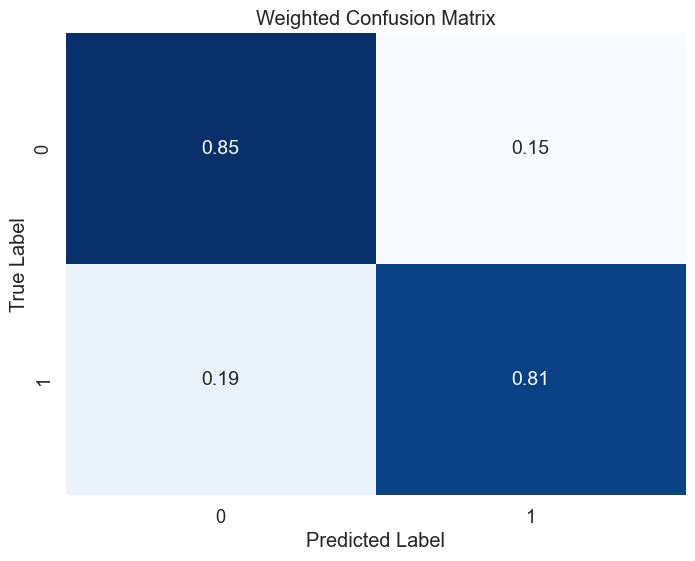

In [103]:
from sklearn.metrics import confusion_matrix

# Evaluate on validation set
model.eval()
predictions = []
true_labels = []

for data in val_loader:
    inputs, labels = data
    outputs = model(inputs)
    predicted = (outputs > 0).squeeze().int()
    predictions.extend(predicted.tolist())
    true_labels.extend(labels.tolist())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Compute sum of true labels in each row (class)
sum_true_labels = conf_matrix.sum(axis=1)

# Normalize each row of the confusion matrix by the sum of true labels
weighted_conf_matrix = conf_matrix / sum_true_labels[:, np.newaxis]

# Plot weighted confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(weighted_conf_matrix, annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 14}, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Weighted Confusion Matrix')
plt.show()


